### This notebook contains code to:
1. Generate candidate solutions for a set of tasks
2. Evaluate set of candidate solutions in one file or a set of files
3. Get evaluation stats by labels, by usage of specific tools (functions), the share of the match score and CI (Ward formula)

Note that the reference solutions (groud truth solutions) need to be in the set you send to the evaluation. 

**Task_editor GUI** allow to edit the task text, generate draft ground ruth solution for the task, manually correct it and leave comments for evaluator on which steps are optional, what arguments are acceptable.

##### Imports

In [1]:
# !pip install -r ../requirements.txt

In [1]:
import os
import sys
import json
from tqdm import tqdm

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print(f"Project root added to path: {project_root}")


Project root added to path: D:\code\GeoBenchX\GeoBenchX


In [2]:
import importlib

import geobenchx.utils
importlib.reload(geobenchx.utils)
from geobenchx.utils import generate_timestamp_id, get_dataframe_info, get_solution_code

import geobenchx.dataclasses
importlib.reload(geobenchx.dataclasses)
from geobenchx.dataclasses import Task, Solution, Step, TaskSet, select_tasks_with_labels


import geobenchx.agent
importlib.reload(geobenchx.agent)
from geobenchx.agent import execute_task

import geobenchx.evaluation
importlib.reload(geobenchx.evaluation)
from geobenchx.evaluation import score_solutions_set, generate_eval_stats, get_eval_stats_by_subsets

from geobenchx.constants import DATA_FOLDER, RESULTS_FOLDER, MODEL_CLAUDE, MODEL_GEMINI, MODEL_GPT_41, MODEL_GEMINI_ADV, MODEL_CLAUDE_mini, MODEL_O3, MODEL_O4, MODEL_GPT_mini, MODEL_CLAUDE_ADV4

import geobenchx.generate_solutions
importlib.reload(geobenchx.generate_solutions)
from geobenchx.generate_solutions import generate_solutions

In [3]:
model = MODEL_GEMINI
temperature = 0

## Generate solutions

In [4]:
# Select file with the task set to solve

tasks_filename = r"tasks_and_reference_solutions_zsx.json"

In [5]:
# Loading tasks from that file

tasks = TaskSet.read_from_file(tasks_filename, DATA_FOLDER)


In [6]:
len(tasks)

4

In [7]:
# Check the set composition
tasks.get_labels_counts()

{<TaskLabels.SPATIAL_OPERATIONS: 'Spatial operations'>: 4,
 <TaskLabels.TASK_SET_03: 'Task Set 03'>: 4,
 <TaskLabels.PROCESS_MERGE_VISUALIZE: 'Process, Merge, Visualize'>: 4,
 <TaskLabels.MERGE_VISUALIZE: 'Merge, Visualize'>: 3,
 <TaskLabels.HEATMAPS_CONTOUR_LINES: 'Heatmaps, Contour Lines'>: 2}

In [8]:
# Check share of unsolvable tasks (tasks with only 1 solution which is to reject task)
labels=['Merge, Visualize', 'Process, Merge, Visualize', 'Spatial operations', 'Heatmaps, Contour Lines']

for label in labels:   
    tasks_with_label = select_tasks_with_labels(tasks, [label])
    tasks_with_function = [task for task in tasks_with_label.tasks
                            if len(task.reference_solutions)==1 and 
                            any(step.function_name == 'reject_task' for step in task.reference_solutions[0].steps)]
    print(f'Share of unsolvable tasks under the label {label}: {len(tasks_with_function)/len(tasks_with_label):.2f} or {len(tasks_with_function)} of {len(tasks_with_label)}.')

Share of unsolvable tasks under the label Merge, Visualize: 0.00 or 0 of 3.
Share of unsolvable tasks under the label Process, Merge, Visualize: 0.00 or 0 of 4.
Share of unsolvable tasks under the label Spatial operations: 0.00 or 0 of 4.
Share of unsolvable tasks under the label Heatmaps, Contour Lines: 0.00 or 0 of 2.


In [9]:
# Creating a standartized name. Each generation will overwrite the candidate solutions and metadata, so if you have 1 output file name, it will be overwritten each time you run the code

output_tasks_filename = f'generated_solutions_{model}_temp_{temperature}.json'

In [10]:
output_tasks_filename


'generated_solutions_gemini-2.5-flash_temp_0.json'

  0%|                                                                   | 0/4 [00:00<?, ?it/s]

Task ID: TASK_251113_142843_001001
Task text: Count the total number of POI points in the 2014 China POI data that fall within Chengdu City.
================================ Human Message =================================

Count the total number of POI points in the 2014 China POI data that fall within Chengdu City.
================================== Ai Message ==================================
Tool Calls:
  load_geodata (0b0f9e1e-4b24-426b-b512-f030245c26b4)
 Call ID: 0b0f9e1e-4b24-426b-b512-f030245c26b4
  Args:
    output_geodataframe_name: china_poi_2014
    geodataset: 2014 China POI
  load_geodata (f0857e70-2aa5-496f-a44e-25dfaa305edf)
 Call ID: f0857e70-2aa5-496f-a44e-25dfaa305edf
  Args:
    geodataset: Chengdu Surface
    output_geodataframe_name: chengdu_surface
================================= Tool Message =================================
Name: load_geodata

Loaded geodata and created GeoDataFrame named chengdu_surface.
Description of GeoDataFrame:
<class 'geopandas.geodat

D:\code\GeoBenchX\GeoBenchX\geobenchx\tools.py:1371: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


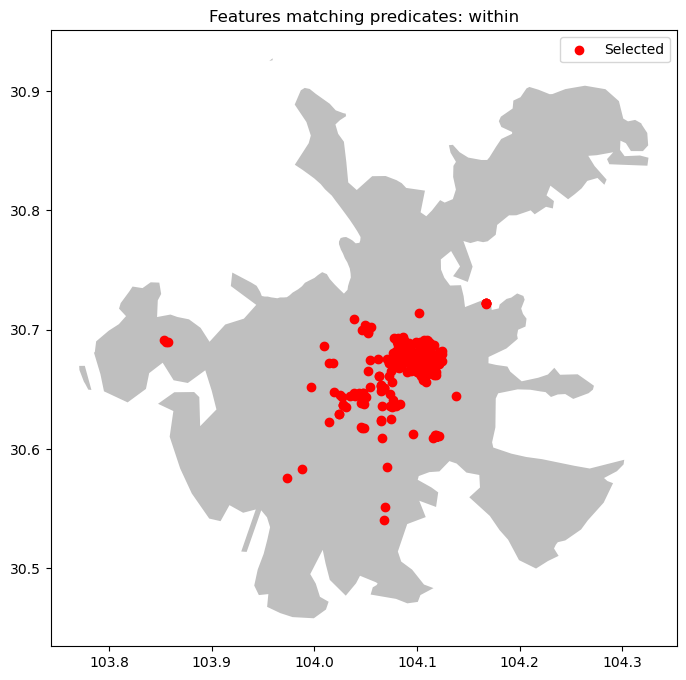

================================= Tool Message =================================
Name: select_features_by_spatial_relationship

Selected 362 features that match ANY of these predicates: within
Results stored in 'chengdu_poi'
================================== Ai Message ==================================

There are 362 POI points from the 2014 China POI data that fall within Chengdu City.
1. load_geodata(output_geodataframe_name='china_poi_2014', geodataset='2014 China POI') 
2. load_geodata(geodataset='Chengdu Surface', output_geodataframe_name='chengdu_surface') 
3. select_features_by_spatial_relationship(reference_geodataframe_name='chengdu_surface', output_geodataframe_name='chengdu_poi', spatial_predicates='['within']', features_geodataframe_name='china_poi_2014') 

Tokens used: input tokens 22037, output_tokens 172


 25%|██████████████▊                                            | 1/4 [00:37<01:51, 37.10s/it]

Task ID: TASK_251113_170215_002002
Task text: Select the areas located within the Jiuzhaigou earthquake zone and classified as forest water conservation zones to be designated as ecological core restoration areas.
================================ Human Message =================================

Select the areas located within the Jiuzhaigou earthquake zone and classified as forest water conservation zones to be designated as ecological core restoration areas.
================================== Ai Message ==================================
Tool Calls:
  load_geodata (bbde2256-88d8-409d-8bc1-de2318af727f)
 Call ID: bbde2256-88d8-409d-8bc1-de2318af727f
  Args:
    geodataset: Jiuzhaigou earthquake zone
    output_geodataframe_name: earthquake_zone
  load_geodata (c8cccba6-f647-4b77-96a5-a04f8e0755fe)
 Call ID: c8cccba6-f647-4b77-96a5-a04f8e0755fe
  Args:
    output_geodataframe_name: forest_conservation_zones
    geodataset: Forest Water Conservation China
================================

 50%|█████████████████████████████▌                             | 2/4 [01:24<01:26, 43.28s/it]

Task ID: TASK_251113_173012_003003
Task text: Calculate the total area of all urban parks in Wuhan. Please follow this exact tool sequence: 1) load_geodata(geodataset='Wuhan Urban Parks', output_geodataframe_name='wuhan_parks'); 2) calculate_column_total(dataframe_name='wuhan_parks', column_name='Area_sqm', output_variable_name='wuhan_parks_total_area'); 3) report the total from wuhan_parks_total_area['total'] (if 'Area_sqm' is missing, try 'Area').
================================ Human Message =================================

Calculate the total area of all urban parks in Wuhan. Please follow this exact tool sequence: 1) load_geodata(geodataset='Wuhan Urban Parks', output_geodataframe_name='wuhan_parks'); 2) calculate_column_total(dataframe_name='wuhan_parks', column_name='Area_sqm', output_variable_name='wuhan_parks_total_area'); 3) report the total from wuhan_parks_total_area['total'] (if 'Area_sqm' is missing, try 'Area').
================================== Ai Message ==========

 75%|████████████████████████████████████████████▎              | 3/4 [02:01<00:40, 40.15s/it]

Task ID: TASK_251113_181735_004004
Task text: Count the total number of POI points in the 2014 China POI data that are located within the Beijing-Tianjin-Hebei region.
================================ Human Message =================================

Count the total number of POI points in the 2014 China POI data that are located within the Beijing-Tianjin-Hebei region.
================================== Ai Message ==================================
Tool Calls:
  load_geodata (18aff800-253f-4399-b3bb-51279645c95b)
 Call ID: 18aff800-253f-4399-b3bb-51279645c95b
  Args:
    geodataset: 2014 China POI
    output_geodataframe_name: china_poi_2014
  load_geodata (7e23b724-46be-44d7-9867-5e568ca2fed8)
 Call ID: 7e23b724-46be-44d7-9867-5e568ca2fed8
  Args:
    geodataset: Beijing-Tianjin-Hebei boundary
    output_geodataframe_name: beijing_tianjin_hebei_boundary
================================= Tool Message =================================
Name: load_geodata

Loaded geodata and created GeoDa

D:\code\GeoBenchX\GeoBenchX\geobenchx\tools.py:1371: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


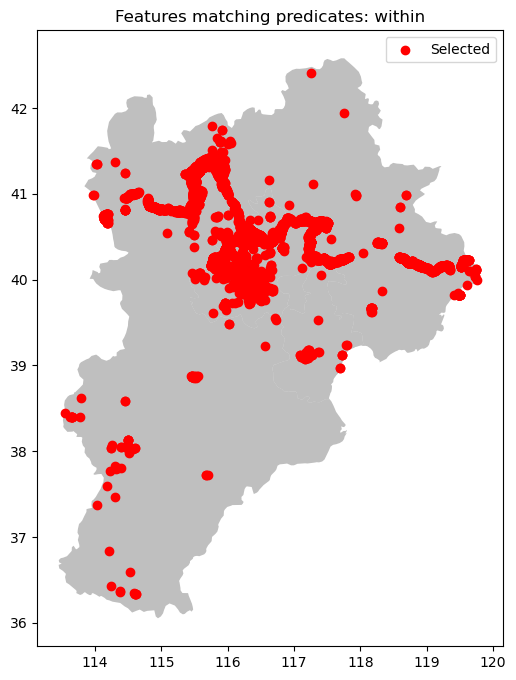

================================= Tool Message =================================
Name: select_features_by_spatial_relationship

Selected 7214 features that match ANY of these predicates: within
Results stored in 'poi_in_beijing_tianjin_hebei'
================================== Ai Message ==================================
Tool Calls:
  calculate_column_total (c15c8b19-1b5d-473a-888c-748d6579bf19)
 Call ID: c15c8b19-1b5d-473a-888c-748d6579bf19
  Args:
    column_name: code
    output_variable_name: total_poi_points
    dataframe_name: poi_in_beijing_tianjin_hebei
================================= Tool Message =================================
Name: calculate_column_total

Calculated total for column 'code' in poi_in_beijing_tianjin_hebei.
- Total value: 19,788,714.00
- Valid rows summed: 7214
- Rows ignored due to missing/non-numeric values: 0
Results stored in 'total_poi_points'.
================================== Ai Message ==================================

The total number of POI p

100%|███████████████████████████████████████████████████████████| 4/4 [02:39<00:00, 39.76s/it]

TOTAL tokens used: total input tokens 97967, total output_tokens 771


In [11]:
# Generating candidate solutions. Double check your output file name above

tasks_solved, _, _ = generate_solutions(tasks, model = model, temperature=temperature, output_filename=output_tasks_filename, max_steps=25, skip_solved=False, capture_history=True)

## Evaluate solutions (single file, single LLM) and get evaluation stats

In [ ]:
# Name of the file with tasks and solutions to score the candidate solutions

taskset_to_evaluate = ''

In [ ]:
# Score solutions in the selected file, reads tasks inside the function

score_solutions_set(tasks_filename=taskset_to_evaluate, folder=RESULTS_FOLDER, model=model, temperature=temperature, skip_scored= False)

In [ ]:
# Generate evaluation stats for all tasks - works on the task set, so read the task file first

taskset_to_evaluate = TaskSet.read_from_file(taskset_to_evaluate, RESULTS_FOLDER)

eval_stats = generate_eval_stats(taskset_to_evaluate)
eval_stats

In [ ]:
# Get evaluations stat for solvable tasks and unsolvable task (reject_task in reference solutions)
# You can use this function to get stats by task label if you added labels while creating tasks

get_eval_stats_by_subsets(taskset_to_evaluate, RESULTS_FOLDER, functions_names=['reject_task'])

## Batch final (evaluation of multiple files and by multiple LLMS)


In [ ]:
files_to_evaluate = [
# input names of files as a Python list
]

In [ ]:
models = [
    MODEL_CLAUDE,
    MODEL_GPT_41,
    MODEL_GEMINI_ADV
]

In [ ]:
for filename in files_to_evaluate:
    for model in models:
        tasks = TaskSet.read_from_file(filename, RESULTS_FOLDER)
        new_filename = 'eval_by_' + model + '_' + filename
        tasks = TaskSet.save_to_file(tasks, new_filename, RESULTS_FOLDER)
        score_solutions_set(tasks_filename=new_filename, folder=RESULTS_FOLDER, model=model, temperature=0, skip_scored=False)

## Calculating final stats

In [ ]:
filenames = [
# files with scored solutions for evaluation as a Python list
]

In [33]:
benchmarking_result_filename = os.path.join(RESULTS_FOLDER, 'benchmark_results.json')
with open(benchmarking_result_filename, 'r') as f:
    benchmarking_res_dict = json.load(f)

In [ ]:
# Resulting stats for all tasks

for filename in filenames:
    tasks = TaskSet.read_from_file(filename, RESULTS_FOLDER)
    bd = generate_eval_stats(tasks)
    benchmarking_res_dict[filename] = bd


In [ ]:
# Resulting stats by label

for filename in filenames:
    bd = get_eval_stats_by_subsets(filename, RESULTS_FOLDER, labels=['Task Set 01', 'Task Set 02', 'Task Set 03', 'Task Set 04', 'Control question'])
    benchmarking_res_dict[filename] = bd

In [ ]:
# Resulting stats by solvable and not

for filename in filenames:
    bd = get_eval_stats_by_subsets(filename, RESULTS_FOLDER, functions_names=['reject_task'])
    benchmarking_res_dict[filename] = bd

In [ ]:
# Saving the results

with open(benchmarking_result_filename, 'w') as f:
    json.dump(benchmarking_res_dict, f, indent=4)